This is a reimplementation of [convolutional variational autoencoder](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb) using `autodiff`. 

In [1]:
import gzip
import numpy as np

import autodiff as ad
from autodiff import initializers
from autodiff import optimizers

In [2]:
train_size = 60000
batch_size = 32
latent_size = 2

In [3]:
def read_mnist_images(fn):
  with gzip.open(fn, 'rb') as f:
    content = f.read()
    num_images = int.from_bytes(content[4:8], byteorder='big')
    height = int.from_bytes(content[8:12], byteorder='big')
    width = int.from_bytes(content[12:16], byteorder='big')
    images = np.fromstring(content[16:], dtype=np.uint8).reshape((num_images, height, width))

  return images

In [4]:
train_images = read_mnist_images('train-images-idx3-ubyte.gz')
test_images = read_mnist_images('t10k-images-idx3-ubyte.gz')

In [5]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

In [6]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [7]:
rui = initializers.RandomUniformInitializer(minval=-0.001, maxval=0.001)
zi = initializers.ZerosInitializer()
oi = initializers.OnesInitializer()

In [8]:
def build_encoder_variables():
  conv0_weight = ad.variable((3, 3, 1, 32), rui)
  conv0_biases = ad.variable((32,), zi)

  conv1_weight = ad.variable((3, 3, 32, 64), rui)
  conv1_biases = ad.variable((64,), zi)

  dense0_weight = ad.variable((2304, latent_size*2), rui)
  dense0_biases = ad.variable((latent_size*2,), zi)

  var_list = [conv0_weight, conv0_biases, conv1_weight, conv1_biases, dense0_weight, dense0_biases]
  return var_list

def build_encoder(images, var_list):
  [conv0_weight, conv0_biases, conv1_weight, conv1_biases, dense0_weight, dense0_biases] = var_list

  conv0 = ad.relu(ad.conv2d(images, conv0_weight, [2, 2], 'VALID') + conv0_biases)
  conv1 = ad.relu(ad.conv2d(conv0, conv1_weight, [2, 2], 'VALID') + conv1_biases)

  reshaped = ad.reshape(conv1, (batch_size, -1))

  params = ad.matmul(reshaped, dense0_weight) + dense0_biases

  return params

In [9]:
def build_decoder_variables():
  dense0_weight = ad.variable((latent_size, 7*7*32), rui)
  dense0_biases = ad.variable((7*7*32,), zi)

  tconv0_weight = ad.variable((3, 3, 64, 32), rui)
  tconv0_biases = ad.variable((64,), zi)

  tconv1_weight = ad.variable((3, 3, 32, 64), rui)
  tconv1_biases = ad.variable((32,), zi)

  tconv2_weight = ad.variable((3, 3, 1, 32), rui)
  tconv2_biases = ad.variable((1,), zi)

  var_list = [dense0_weight, dense0_biases, tconv0_weight, tconv0_biases, tconv1_weight, tconv1_biases, tconv2_weight, tconv2_biases]

  return var_list

def build_decoder(z, var_list):
  dense0_weight, dense0_biases, tconv0_weight, tconv0_biases, tconv1_weight, tconv1_biases, tconv2_weight, tconv2_biases = var_list
  dense0 = ad.relu(ad.matmul(z, dense0_weight) + dense0_biases)

  reshaped = ad.reshape(dense0, [-1, 7, 7, 32])

  tconv0 = ad.relu(ad.conv2d_transpose(reshaped, tconv0_weight, [2, 2], 'SAME') + tconv0_biases)
  tconv1 = ad.relu(ad.conv2d_transpose(tconv0, tconv1_weight, [2, 2], 'SAME') + tconv1_biases)
  tconv2 = ad.conv2d_transpose(tconv1, tconv2_weight, [1, 1], 'SAME') + tconv2_biases
  return tconv2

In [10]:
log2pi = np.log(2. * np.pi).astype('float32')

def log_normal_pdf(sample, mean, logvar, axis=1):
  return ad.reduce_sum(
    -.5 * ((sample - mean) * (sample - mean) * ad.exp(-logvar) + logvar + log2pi),
    axis=axis)

In [11]:
graph = ad.Graph()
with graph.as_default_graph():
  images = ad.placeholder((batch_size, 28, 28, 1))
  encoder_var_list = build_encoder_variables()
  params = build_encoder(images, encoder_var_list)

  mean = ad.slice(params, [0, 0], [batch_size, latent_size])
  logvar = ad.slice(params, [0, latent_size], [batch_size, latent_size])

  eps = ad.placeholder(mean.shape)
  z = eps * ad.exp(logvar * .5) + mean

  decoder_var_list = build_decoder_variables()
  x_logits = build_decoder(z, decoder_var_list)

  cross_ent = ad.sigmoid_cross_entropy_loss(images, x_logits)

  logpx_z = -ad.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = ad.reduce_sum(-0.5 * (z * z + log2pi), axis=1)
  logqz_x = log_normal_pdf(z, mean, logvar)

  loss = -ad.reduce_mean(logpx_z + logpz - logqz_x)

In [12]:
graph.initialize_variables()
runtime = ad.RunTime()
graph.set_runtime(runtime)

var_list = encoder_var_list + decoder_var_list
optimizer = optimizers.AdamOptimizer(alpha=1e-4, beta1=0.9, beta2=0.999, epsilon=1e-7)

In [13]:
epochs = 10

for i in range(epochs):  
  indices = np.random.permutation(train_images.shape[0])
  
  for j in range(train_images.shape[0] // batch_size):    
    feed_dict = {
        images: train_images[j:j+batch_size],
        eps: np.random.normal(size=(batch_size, latent_size))}
    with runtime.forward_backward_cycle():
      grads_and_vars = optimizer.compute_gradients(loss, feed_dict, var_list)
      loss_val = loss.forward(feed_dict)
    optimizer.apply_gradients(grads_and_vars)

    if j % 100 == 0:
      print('epochs', i, 'iteration', j, 'loss', loss_val)

  graph.save_variables('epoch_%d' % i)  
  print()
graph.save_variables('final')    

epochs 0 iteration 0 loss 543.4273681794048
epochs 0 iteration 100 loss 507.6993093023551
epochs 0 iteration 200 loss 285.6650120875215
epochs 0 iteration 300 loss 220.88359849036524
epochs 0 iteration 400 loss 211.67389877682945
epochs 0 iteration 500 loss 217.08146521970582
epochs 0 iteration 600 loss 204.57685355406267
epochs 0 iteration 700 loss 218.347781734694
epochs 0 iteration 800 loss 214.8973430552046
epochs 0 iteration 900 loss 214.15313261498028
epochs 0 iteration 1000 loss 195.32004535630614
epochs 0 iteration 1100 loss 195.28870161548224
epochs 0 iteration 1200 loss 198.1463650552102
epochs 0 iteration 1300 loss 202.15386614577523
epochs 0 iteration 1400 loss 195.12908076906513
epochs 0 iteration 1500 loss 181.36371437339056
epochs 0 iteration 1600 loss 190.1796591442206
epochs 0 iteration 1700 loss 182.88186367226263
epochs 0 iteration 1800 loss 170.0311696997041

epochs 1 iteration 0 loss 185.40632933810244
epochs 1 iteration 100 loss 182.49355656310848
epochs 1 iterati

epochs 9 iteration 400 loss 147.65560194206216
epochs 9 iteration 500 loss 159.33414962644378
epochs 9 iteration 600 loss 156.2289919634672
epochs 9 iteration 700 loss 165.30098825793445
epochs 9 iteration 800 loss 160.38956929573465
epochs 9 iteration 900 loss 156.7507857134949
epochs 9 iteration 1000 loss 153.97725090304544
epochs 9 iteration 1100 loss 155.69792737411143
epochs 9 iteration 1200 loss 162.49232835019035
epochs 9 iteration 1300 loss 167.48335221034057
epochs 9 iteration 1400 loss 172.5129459100362
epochs 9 iteration 1500 loss 157.60927631619143
epochs 9 iteration 1600 loss 165.52755059176218
epochs 9 iteration 1700 loss 154.3882929951135
epochs 9 iteration 1800 loss 148.2239369103532



In [21]:
n = 20
digit_size = 28
norm_x = np.random.normal(size=(1000,))
norm_y = np.random.normal(size=(1000,))

grid_x = np.quantile(norm_x, np.linspace(0.05, 0.95, n))
grid_y = np.quantile(norm_y, np.linspace(0.05, 0.95, n))

image_width = digit_size*n
image_height = image_width
image = np.zeros((image_height, image_width))

In [22]:
test_graph = ad.Graph()
with test_graph.as_default_graph():
  z = ad.placeholder((1, latent_size))
  encoder_var_list = build_encoder_variables()
  decoder_var_list = build_decoder_variables()
  x_logits = build_decoder(z, decoder_var_list)

weights = np.load('epoch_7.npy', allow_pickle=True).item()
for i, v in enumerate(decoder_var_list):
  v.set_val(weights[v.name])

sigmoid = lambda x: 1. / (1 + np.exp(-x))

runtime = ad.RunTime()
test_graph.set_runtime(runtime)


In [23]:
import matplotlib.pyplot as plt

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_value = np.array([[xi, yi]])
    feed_dict = {z: z_value}
    with runtime.forward_backward_cycle():
      x_logits_value = x_logits.forward(feed_dict)
      
    probs_value = sigmoid(x_logits_value)
    digit = np.reshape(probs_value[0], (digit_size, digit_size))
    image[i * digit_size: (i + 1) * digit_size,
          j * digit_size: (j + 1) * digit_size] = digit

(-0.5, 559.5, 559.5, -0.5)

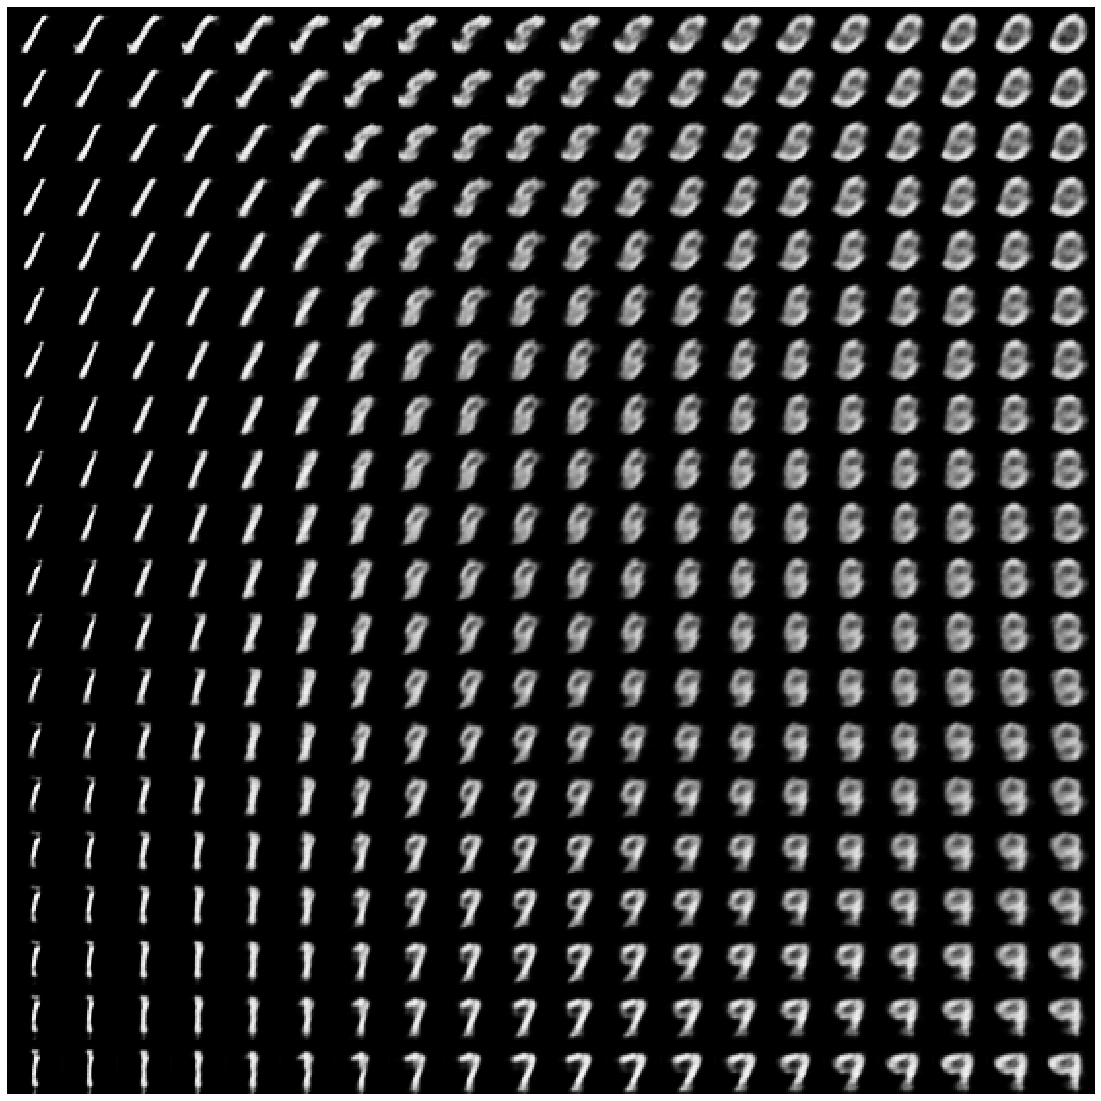

In [24]:
plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='Greys_r')
plt.axis('Off')